# About

- RFM Segmentation
- RFM and Churn Connection

# Preparation

## Libraries

In [1]:
import pandas as pd

In [2]:
from dotenv import load_dotenv
import os

In [3]:
import maika_eda_pandas as mk

In [ ]:
from src.core.transforms import (
    transform_transactions_df,
    transform_customers_df,
    get_customers_screenshot_summary_from_transactions_df,
    rfm_segment,
    add_churn_status,
)

In [5]:
import plotly.express as px
import plotly.graph_objects as go

## Environment

In [6]:
load_dotenv()

True

In [7]:
SEED_CUSTOMERS=os.getenv("SEED_CUSTOMERS")
SEED_TRANSACTIONS=os.getenv("SEED_TRANSACTIONS")

In [8]:
OBSERVED_DATE = pd.Timestamp('2025-12-31')

## Data

### Read

In [9]:
customers_df = pd.read_csv(f"../{SEED_CUSTOMERS}")

In [10]:
transactions_df = pd.read_csv(f"../{SEED_TRANSACTIONS}")

In [11]:
mk.read_data_info(transactions_df)

Number of columns: 3
Column names: ['customer_id', 'transaction_date', 'amount']
Number of rows: 46,704
Data Preview: 

  customer_id transaction_date  amount
0      C00000       2025-09-10  195.78
1      C00000       2025-09-12   50.87
2      C00000       2025-10-01  133.25
3      C00000       2025-10-16   37.44
4      C00000       2025-10-18  101.95


In [12]:
mk.read_data_info(customers_df)

Number of columns: 3
Column names: ['customer_id', 'signup_date', 'true_lifetime_days']
Number of rows: 3,000
Data Preview: 

  customer_id signup_date  true_lifetime_days
0      C00000  2025-08-22                 204
1      C00001  2025-03-07                 365
2      C00002  2025-08-18                  48
3      C00003  2025-09-22                  84
4      C00004  2025-05-28                 113


### Transform

In [13]:
transactions_df = transform_transactions_df(transactions_df)

In [14]:
customers_df = transform_customers_df(customers_df)

### Summary Data

In [15]:
customers_screenshot_summary_df = get_customers_screenshot_summary_from_transactions_df(
    transactions_df = transactions_df,
    observed_date = OBSERVED_DATE,
    column_names = ['customer_id', 'transaction_date', 'amount']
)

In [16]:
mk.read_data_info(customers_screenshot_summary_df)

Number of columns: 7
Column names: ['customer_id', 'period_total_amount', 'period_first_transaction_date', 'period_last_transaction_date', 'period_transaction_count', 'days_until_observed', 'period_tenure_days']
Number of rows: 2,892
Data Preview: 

  customer_id  period_total_amount period_first_transaction_date  \
0      C00000              1222.85                    2025-09-10   
1      C00001              1228.46                    2025-03-17   
2      C00002               910.64                    2025-08-20   
3      C00003               114.71                    2025-10-04   
4      C00004              2018.94                    2025-06-08   

  period_last_transaction_date  period_transaction_count  days_until_observed  \
0                   2025-12-31                        12                    0   
1                   2025-12-20                        19                   11   
2                   2025-09-26                        11                   96   
3                

# Analysis

## RFM

Rule: Higher Score -> Better

### Segment

In [17]:
## RECENCY
customers_screenshot_summary_df['R_score'] = pd.qcut(
    customers_screenshot_summary_df['days_until_observed'],
    q=5,
    labels=[5, 4, 3, 2, 1]
)

In [18]:
## FREQUENCY
customers_screenshot_summary_df['F_score'] = pd.qcut(
    customers_screenshot_summary_df['period_transaction_count'],
    q=5,
    labels=[1, 2, 3, 4, 5]
)

In [19]:
## MONETARY VALUE
customers_screenshot_summary_df['M_score'] = pd.qcut(
    customers_screenshot_summary_df['period_total_amount'],
    q=5,
    labels=[1, 2, 3, 4, 5]
)

In [20]:
score_cols = ["R_score", "F_score", "M_score"]

In [21]:
customers_screenshot_summary_df[score_cols] = (
    customers_screenshot_summary_df[score_cols]
    .apply(pd.to_numeric, errors="coerce")
)

In [22]:
customers_screenshot_summary_df[["customer_id"] + score_cols].head()

,customer_id,R_score,F_score,M_score
0,C00000,5,3,4
1,C00001,4,4,4
2,C00002,2,3,4
3,C00003,3,1,1
4,C00004,2,4,5


### Assign Labels

In [23]:
customers_screenshot_summary_df['rfm_segment'] = customers_screenshot_summary_df.apply(rfm_segment, axis=1)

In [24]:
customers_screenshot_summary_df[["customer_id", "rfm_segment"] + score_cols]

,customer_id,rfm_segment,R_score,F_score,M_score
0,C00000,Loyal Customers,5,3,4
1,C00001,Champions,4,4,4
2,C00002,At Risk,2,3,4
3,C00003,Others,3,1,1
4,C00004,At Risk,2,4,5
...,...,...,...,...,...
2887,C02995,Loyal Customers,5,4,3
2888,C02996,Others,3,3,3
2889,C02997,Loyal Customers,4,4,3
2890,C02998,Champions,5,4,5


### Segment Distributions

In [25]:
## RECENCY
col_name = 'rfm_segment'
styled_df, fig = mk.frequency_table_and_bar(customers_screenshot_summary_df, col_name)
mk.stack_plotly_figure_with_styled_dataframe(fig, styled_df)

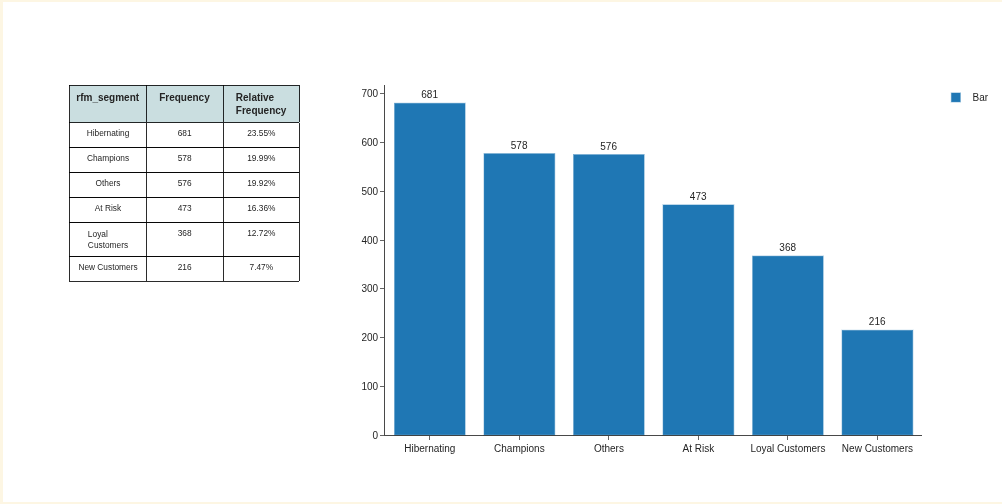

Observation:
- Around 30% of our customers are quality ones (Champions, Loyal Customers)
- Hibernating and At Risk accounts for a sizable proportion (24%, 17%)
- New Customers have a smaller proportion


In [26]:
temp_summary_df = (
    customers_screenshot_summary_df
    .groupby("rfm_segment")
    .agg(
        mean_monetary=("period_total_amount", "mean"),
        total_customers=("customer_id", "size")
    )
)

temp_summary_df['expected_total_monetary'] = temp_summary_df['mean_monetary'] * temp_summary_df['total_customers']

(
    temp_summary_df
    .style
    .background_gradient(subset=['expected_total_monetary'])
    .format({"expected_total_monetary": "{:,.2f}"})
)

,mean_monetary,total_customers,expected_total_monetary
rfm_segment,,,
At Risk,1068.314313,473,"505,312.67"
Champions,2314.385052,578,"1,337,714.56"
Hibernating,229.137695,681,"156,042.77"
Loyal Customers,613.213098,368,"225,662.42"
New Customers,314.474398,216,"67,926.47"
Others,743.895208,576,"428,483.64"


The monetary value of Champions is almost x3 of At Risk customer, showing that Champions should always be prioritized.

In [27]:
(
    customers_screenshot_summary_df
    .groupby("rfm_segment")
    .agg(
        mean_recency=("days_until_observed", "mean"),
        mean_frequency=("period_transaction_count", "mean"),
        mean_monetary=("period_total_amount", "mean")
    )
    .style
    .background_gradient(axis=None)
    .format(precision=4)
)

,mean_recency,mean_frequency,mean_monetary
rfm_segment,,,
At Risk,166.5159,18.6977,1068.3143
Champions,4.7284,36.4723,2314.3851
Hibernating,196.6814,3.9530,229.1377
Loyal Customers,6.7310,14.8750,613.2131
New Customers,9.2407,5.3519,314.4744
Others,56.0677,12.9462,743.8952


In [28]:
customers_df['true_lifetime_days'].mean()

156.771

At Risk and Champions Customers have even higher mean recency than true lifetime mean -> These groups are more likely to have customers who have ALREADY churned.

In [29]:
(
    customers_screenshot_summary_df
    .pivot_table(
        index="R_score",
        columns="F_score",
        values="period_total_amount",
        aggfunc="mean"
    )
    .style
    .background_gradient(axis=None)
    .format(precision=4)
)

F_score,1,2,3,4,5
R_score,,,,,
1,139.6271,369.8240,736.0166,1119.5458,1853.3557
2,137.1728,356.0228,695.6363,1133.9941,1755.3493
3,158.8849,367.8214,676.0817,1090.9403,2290.4146
4,186.3466,377.8075,702.2001,1086.4568,2549.9372
5,166.8479,384.6243,663.0286,1231.1704,2757.5781


This data seem to have high linear correlation, meaning:
- Those who purchase higher in value is likely also purchased more frequently and have purchased recently.

## RFM & Churn

In [30]:
customers_screenshot_summary_df = add_churn_status(customers_df, customers_screenshot_summary_df, OBSERVED_DATE)

In [31]:
ordered_df, fig = mk.create_stacked_count_bar_chart(customers_screenshot_summary_df, "rfm_segment", "is_churn")
fig

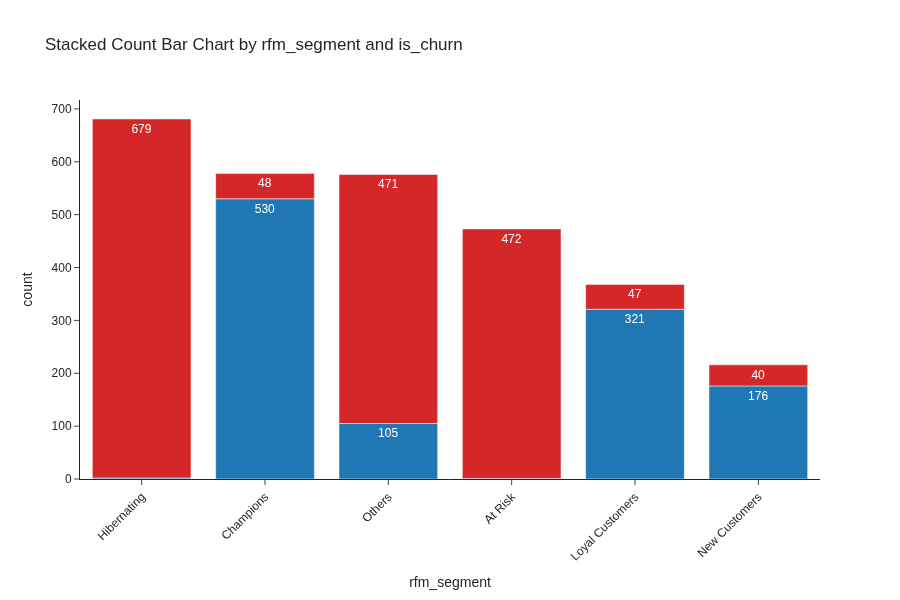

- Hibernating and At Risk customers have an extremely high Churn rate (looking at the ratio in the above chart) which means despite their potential, most of these customer groups are beyond saving.
- -> Wasteful

## Customer Priority

Which customers should we prioritize in our retention efforts?
Knowing that:
- Some customers are already beyond saving
- R,F,M is equally important
    - R: avoid over-treatment (pushing sales on customers who would have bought anyways)
    - F: bring more value (CLV)
    - M: bring more value (CLV)
So:
- We can only choose alive customers for treatment.
- We need to reverse Recency scoring: More recent -> Less "risk" -> Lower priority in saving.

In [32]:
alive_customers = customers_screenshot_summary_df[customers_screenshot_summary_df['is_churn'] == 0]

In [33]:
stat_df = mk.distribution_statistics_table(alive_customers, value_col='days_until_observed')
fig = mk.create_histogram_plotly(alive_customers, 'days_until_observed')
mk.stack_plotly_figure_with_dataframe(stat_df, fig)

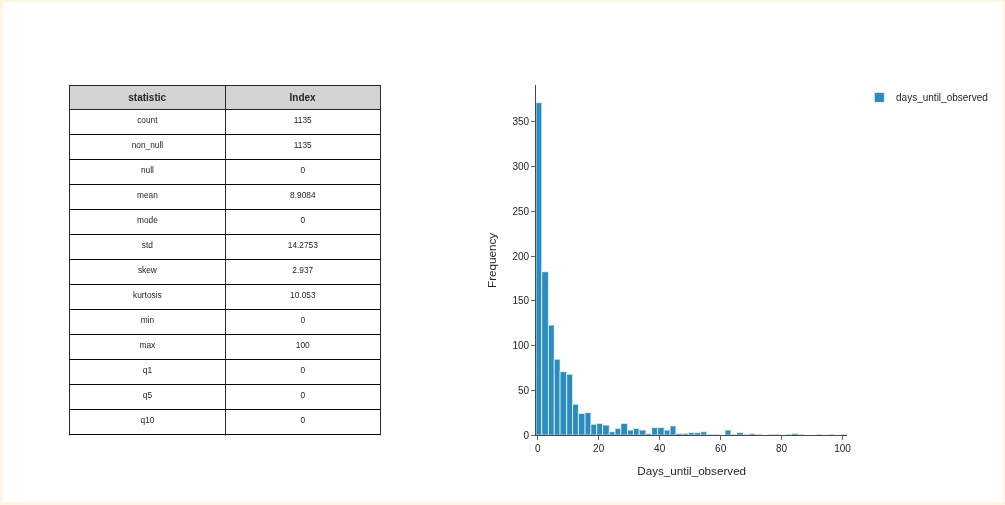

Problem: When we limit only alive customers, the data distribution for recency becomes more skewed -> Can not do 5 quantiles.

Solution: Should not matter, we can use 4 quantiles. I'm getting the mean score, which is only used for ranking customers (relatively), so we do not need to care about the scale anyways.

In [34]:
alive_customers['R_risk'] = pd.qcut(
    alive_customers['days_until_observed'],
    q=4,
    labels=[1, 2, 3, 4]
)

In [35]:
alive_customers["priority_score"] = (
    alive_customers[["M_score", "F_score", "R_risk"]]
    .mean(axis=1)
)

In [36]:
(
    alive_customers
    .groupby('rfm_segment')
    .agg(mean_priority_score=('priority_score', 'mean'))
)

,mean_priority_score
rfm_segment,
At Risk,3.333333
Champions,3.727044
Hibernating,2.833333
Loyal Customers,2.872274
New Customers,2.143939
Others,2.600000


In [37]:
segment_summary = (
    alive_customers
    .groupby("rfm_segment")
    .agg(
        mean_priority_score=("priority_score", "mean"),
        no_customers=("priority_score", "size"),
        mean_days_until_observed=("days_until_observed", "mean"),
        mean_period_total_amount=("period_total_amount", "mean"),
        mean_period_transaction_count=("period_transaction_count", "mean")
    )
)

segment_summary["weighted_priority_score"] = (
    segment_summary["mean_priority_score"] * segment_summary["no_customers"]
)

segment_summary.sort_values(by=['weighted_priority_score'], ascending=False)

,mean_priority_score,no_customers,mean_days_until_observed,mean_period_total_amount,mean_period_transaction_count,weighted_priority_score
rfm_segment,,,,,,
Champions,3.727044,530,3.750943,2299.639189,36.586792,1975.333333
Loyal Customers,2.872274,321,5.433022,595.673988,14.869159,922.000000
New Customers,2.143939,176,7.795455,316.151250,5.318182,377.333333
Others,2.600000,105,44.933333,373.163524,5.990476,273.000000
Hibernating,2.833333,2,96.000000,419.720000,5.000000,5.666667
At Risk,3.333333,1,97.000000,746.120000,13.000000,3.333333


After being weighted, because there are so little observations in Hibernating and At Risk groups, their priority fell.

In [38]:
alive_customers['priority_group'] = pd.qcut(
    alive_customers['priority_score'],
    q=4,
    labels=[1, 2, 3, 4]
)

In [39]:
px.scatter(
    alive_customers,
    x="period_total_amount",
    y="days_until_observed",
    color="priority_group"
)

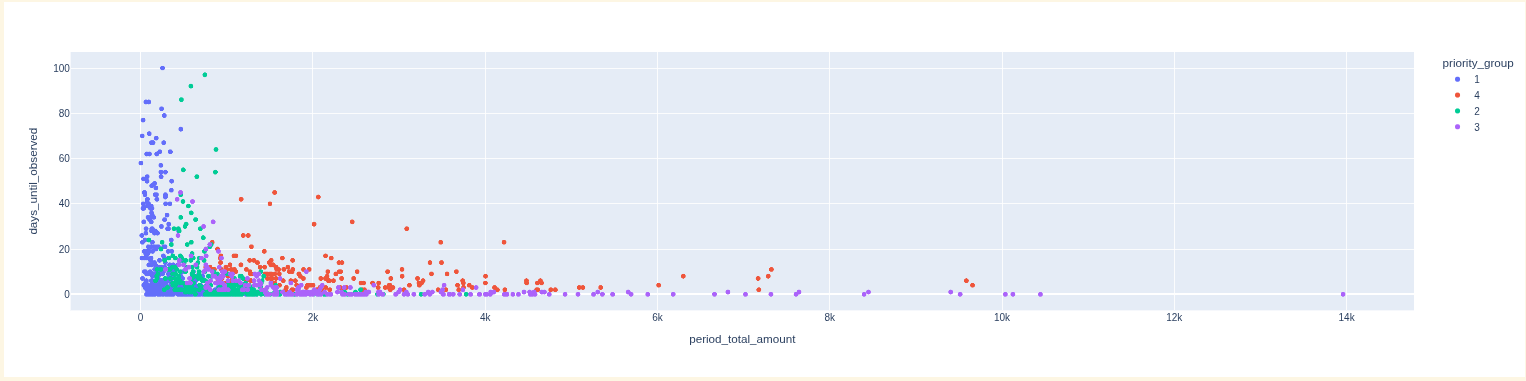

Observations:
- Low Priority (1) is more likely to have bought a longer while back since the time observed, however, with less value.
- Medium High Priority (3) has even more extreme value purchases than High Priority (4) group. But the former is indeed more recent.
- High Priority (4) generally have both recency risk and monetary value higher than other groups. 

But we clearly see a problem with this RFM segmentation method:
- Inaccurate
    - RFM segmentation definitions are very abstract. We only use distributions to assign into scores, without looking at the TRUE lifetime of a customer. This means: at the time of segmentation, some customers have ALREADY died -> can not save anymore. 
- Insufficient
    - RFM segmetation ignores churn status and churn risk. And even if we use mean weighted scores for ranking priority customer groups, the score ignores priorities and treats each criteria in RFM as the same. However, it has been stated before that Recency is the most important aspect in RFM (ref: Visualizing RFM Segmentation), because it shows whether the customer can be saved/ are they still here with our business.
    - RFM segmentation also doesn't provide clear actions. It doesn't provide an uplift effect -> doesn't know who needs saving more -> it mistakingly place higher priority to Champions and Loyal Customers, when these customer groups likely do not need saving!
- Short-term vision
    - RFM segmentation can't look ahead. It uses distributions as a base (when we are not sure about manual the definition of each score). However, with each observation time the distribution can SHIFT.
    - Example: In this period, median recency is 40. Which means any recency larger than 40 already sounds pretty bad. Then in another period (6 months later), let's say our service made a bad choice, that disappointed our customers and more people haven't bought in a while. The whole distribution of recency shifts to the left. Now, the median is 70! So any customers with recency after this threshold is risky, but also customers before that new threshold. Instead, RFM just treats the most extreme values of recency as risky, which is dangerous.
    - If we listen to RFM:
        - Instead of trying to save people with recency of 40 people, we ended up only trying to save people with extreme recency. These people with 40 recency are untreated and will churn eventually -> the business lose the customers and the money.
        - The people with extreme recency are likely beyond saving -> We waste money trying to save them.

We need a new solution that can incorporate:
- Churn Risk
- Uplift Effect

I believe they will form better priority scores AND decide on an action much better.
